In [1]:
import sys
import os

import numpy as np
import cv2
import torch
from torch.utils.data import DataLoader

sys.path.insert(0, os.path.abspath('..'))

from src.utils.load_cfg import ConfigLoader
from src.factories import ModelFactory
from src.factories import DatasetFactory
from src.utils.misc import MiscUtils

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})


dataset_cfg = '../configs/dataset_cfgs/epickitchens_short.yaml'
train_cfg = '../configs/train_cfgs/train_tbn_short.yaml'
sample_id = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Deprocess data for visualization
def deprocess_rgb(rgb, num_segments):
    rgb = rgb.cpu().numpy()
    assert rgb.shape[0] == 1
    _, _, h, w = rgb.shape
    rgb = rgb.reshape([num_segments, 3, h, w]).transpose(0, 2, 3, 1)
    rgb *= 1  # std
    rgb += np.array([104, 117, 128])  # mean
    rgb = rgb.astype(np.uint8)
    return rgb


def deprocess_spec(spec, num_segments):
    spec = spec.cpu().numpy()
    assert spec.shape[0] == 1
    _, _, h, w = spec.shape
    spec = spec.reshape([num_segments, h, w])
    return spec


def display_input(sample, num_segments):
    sns.set_style("whitegrid", {'axes.grid' : False})
    # Deprocess inputs
    rgb = deprocess_rgb(sample['RGB'], num_segments)
#     spec = deprocess_spec(sample['Spec'], num_segments)

    # Display input RGB
    fig, axes = plt.subplots(1, num_segments, figsize=(20, 5))
    #fig.suptitle('='*30+'\n  RGB\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(cv2.cvtColor(rgb[i], cv2.COLOR_BGR2RGB))
        #axes[i].axis('off')

    # Display input Spec
#     fig, axes = plt.subplots(1, num_segments, figsize=(10, 5))
#     fig.suptitle('='*30+'\n  Spec\n'+'='*30, fontsize=15)
#     fig.tight_layout()
#     fig.subplots_adjust(top=0.95)
#     for i in range(num_segments):
#         axes[i].imshow(spec[i], cmap='viridis')
#         axes[i].axis('off')

In [3]:
def load(model_cfg, dataset_cfg, train_cfg, new_num_segments=None):
    # Load configurations
    model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
    dataset_name, dataset_params = ConfigLoader.load_dataset_cfg(dataset_cfg)
    train_params = ConfigLoader.load_train_cfg(train_cfg)
    
    if new_num_segments is not None:
        model_params['num_segments'] = new_num_segments

    dataset_params.update({
        'modality': model_params['modality'],
        'num_segments': model_params['num_segments'],
        'new_length': model_params['new_length'],
    })

    # Build model
    model_factory = ModelFactory()
    model = model_factory.generate(model_name, device=device, model_factory=model_factory, **model_params)
    model.load_model(weight)
    model = model.to(device)

    # Get training augmentation and transforms
    train_augmentation = MiscUtils.get_train_augmentation(model.modality, model.crop_size)
    train_transform, val_transform = MiscUtils.get_train_val_transforms(
        modality=model.modality,
        input_mean=model.input_mean,
        input_std=model.input_std,
        scale_size=model.scale_size,
        crop_size=model.crop_size,
        train_augmentation=train_augmentation,
    )

    # Data loader
    dataset_factory = DatasetFactory()
    loader_params = {
        'batch_size': train_params['batch_size'],
        'num_workers': train_params['num_workers'],
        'pin_memory': True,
    }

    val_dataset = dataset_factory.generate(dataset_name, mode='val', transform=val_transform, **dataset_params)
    val_loader = DataLoader(val_dataset, shuffle=False, **loader_params)
    return model, val_loader


def run_experiment(model_cfg, weight, title='', display=False, new_num_segments=None):
    model, val_loader = load(model_cfg, dataset_cfg, train_cfg, new_num_segments)
    
    # Get a sample
    for i, (sample, target) in enumerate(val_loader):
        sample = {k: v.to(device) for k, v in sample.items()}
        target = {k: v.to(device) for k, v in target.items()}

        if i == sample_id:
            break
            
    if display:
        display_input(sample, model.num_segments)
    
    # Forward
    with torch.no_grad():
        model.eval()
        model(sample)
        attn = model._attn
        # hallu = model._hallu
        
        # Run hallucination with single frame groundtruth memory
        hallu, _ = model.hallu_model(attn, hidden=None)
    
    # Compute SSIM
    ssim_fn = model.belief_criterion
    ssim_list = np.zeros(model.num_segments)
    for t in range(1, model.num_segments):
        ssim = -ssim_fn(attn[0, t].unsqueeze(0), hallu[0, t-1].unsqueeze(0))
        ssim_list[t] = ssim.item()
        
    
    attn = attn[0].mean(dim=1).cpu().detach().numpy()
    hallu = hallu[0].mean(dim=1).cpu().detach().numpy()
    vmin = min(attn.min(), hallu.min())
    vmax = max(attn.max(), hallu.max())
    
    # Visualize
    sns.set_style("whitegrid", {'axes.grid' : False})
    prefix_len = model.num_segments - len(hallu)
    fig, axes = plt.subplots(2, model.num_segments, figsize=(30, 6))
    for t in range(model.num_segments):
        axes[0, t].imshow(attn[t], vmin=vmin, vmax=vmax)
        if t >= 1:
            axes[1, t].imshow(hallu[t-1], vmin=vmin, vmax=vmax)
            axes[1, t].set_xlabel('{:.02f}'.format(ssim_list[t-1]), fontsize=15)        
        
    # ----------------------------------------------------------------------------
    # Plot SSIM
    sns.set_theme()
    fig, ax = plt.subplots(1, 1, figsize=(20, 7))
    ax.plot(np.arange(model.num_segments), ssim_list, '-o', label='ssim')
    #ax.plot(np.arange(model.num_segments), [theta]*model.num_segments, '--', label='theshold')
    for t in range(model.num_segments):
        ax.annotate('{:.4f}'.format(ssim_list[t]), (t, ssim_list[t]), 
                    textcoords='offset points', xytext=(0,10), ha='center', fontsize=15)
    ax.set_xlabel('t', fontsize=15)
    ax.set_ylabel('SSIM', fontsize=15)
    ax.set_xticks(np.arange(model.num_segments))
    plt.legend()
    
    return ssim_list

# Pipeline3 - 224x224 - layer3_0

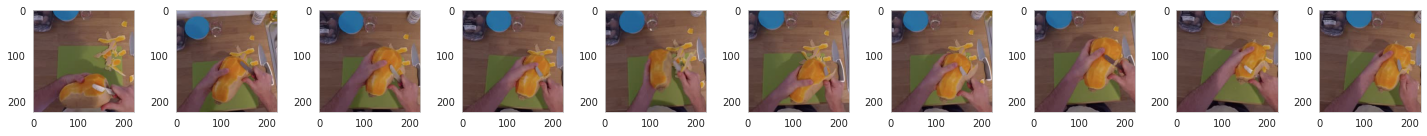

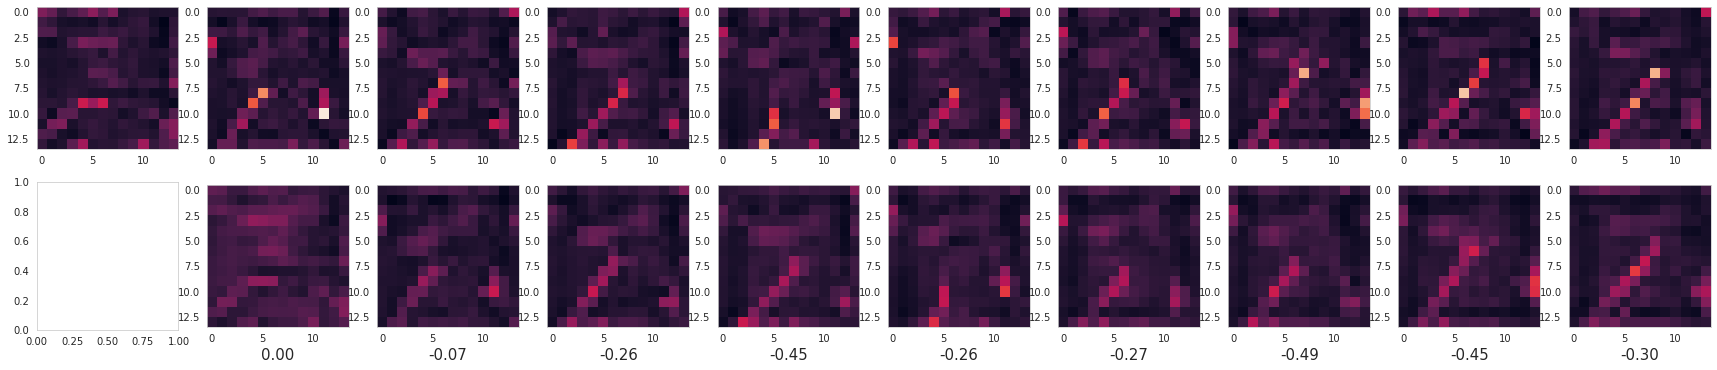

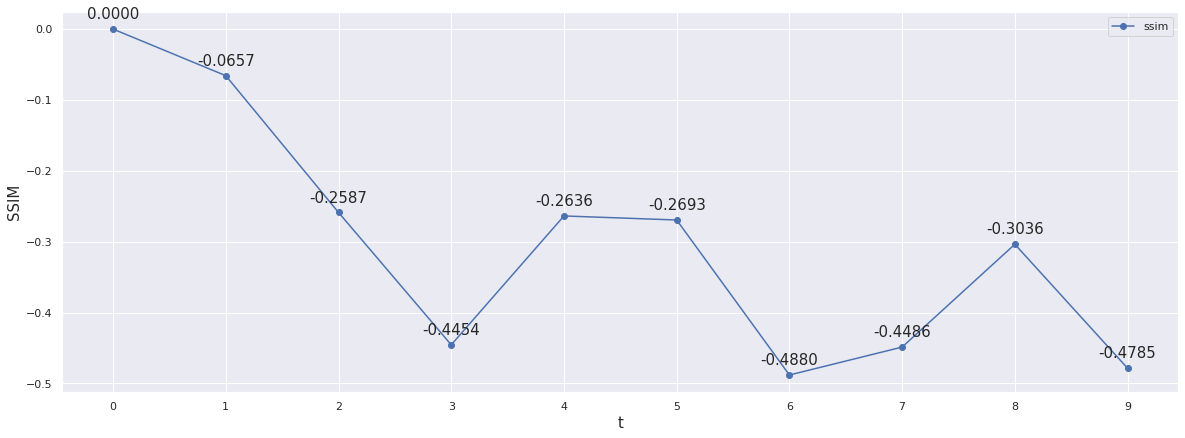

In [4]:
model_cfg = '../configs/model_cfgs/pipeline3_rgbspec_san19pairfreeze_halluconvlstm2.yaml'
weight = '/home/knmac/Dropbox/SparseSensing/DGX_training_logs/pipeline3_rgbspec_san19pairfreeze_halluconvlstm2/best.model'
ssim1 = run_experiment(model_cfg, weight, title=weight.split('/')[-2], display=True, new_num_segments=10)

# Pipeline3 - 112x112 - layer3_0

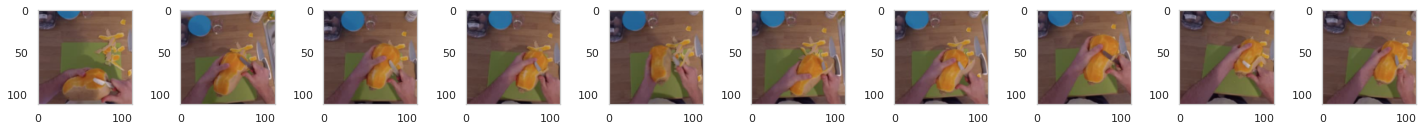

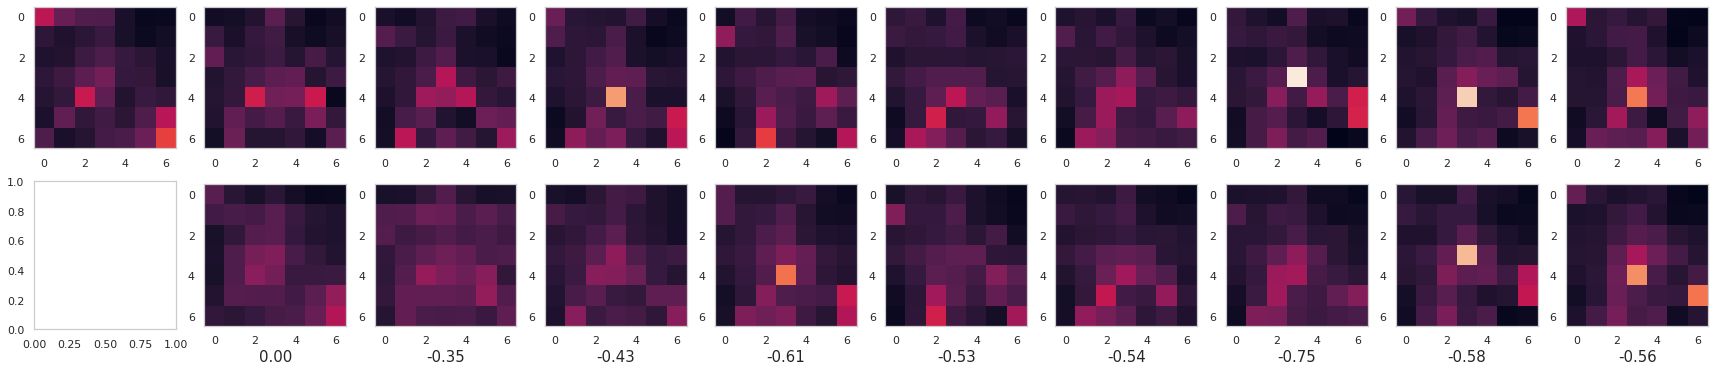

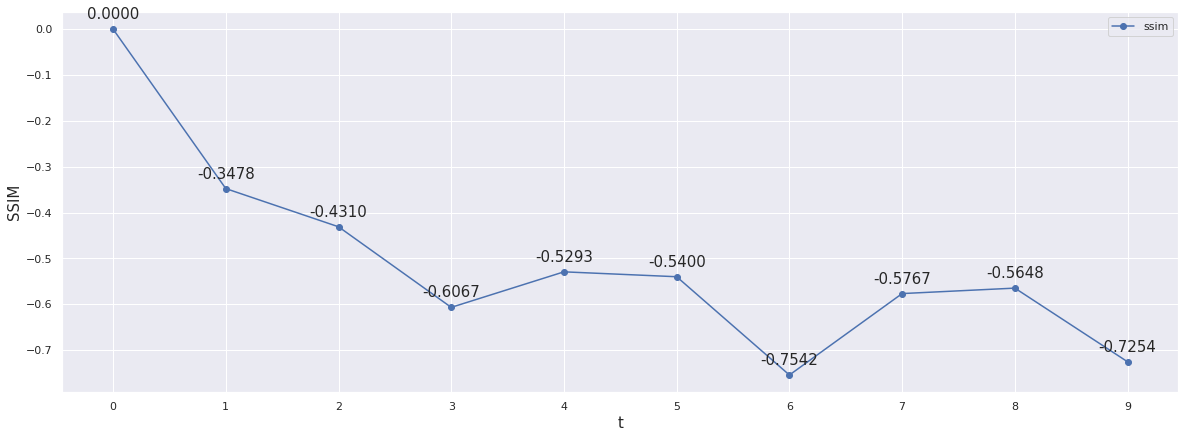

In [5]:
model_cfg = '../configs/model_cfgs/pipeline3_rgbspec_san19pairfreeze112@layer3-0_halluconvlstm2.yaml'
weight = '/home/knmac/Dropbox/SparseSensing/DGX_training_logs/pipeline3_rgbspec_san19pairfreeze112@layer3-0_halluconvlstm2/best.model'
ssim2 = run_experiment(model_cfg, weight, title=weight.split('/')[-2], display=True, new_num_segments=10)

# Pipeline3 - 112x112 - layer2_3

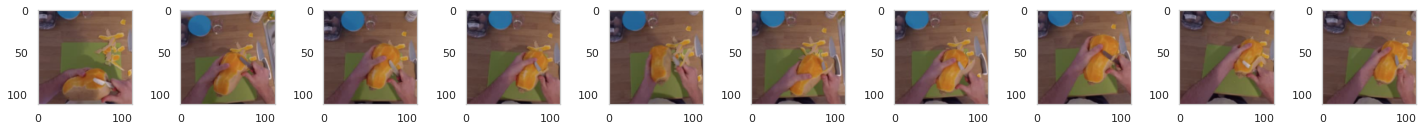

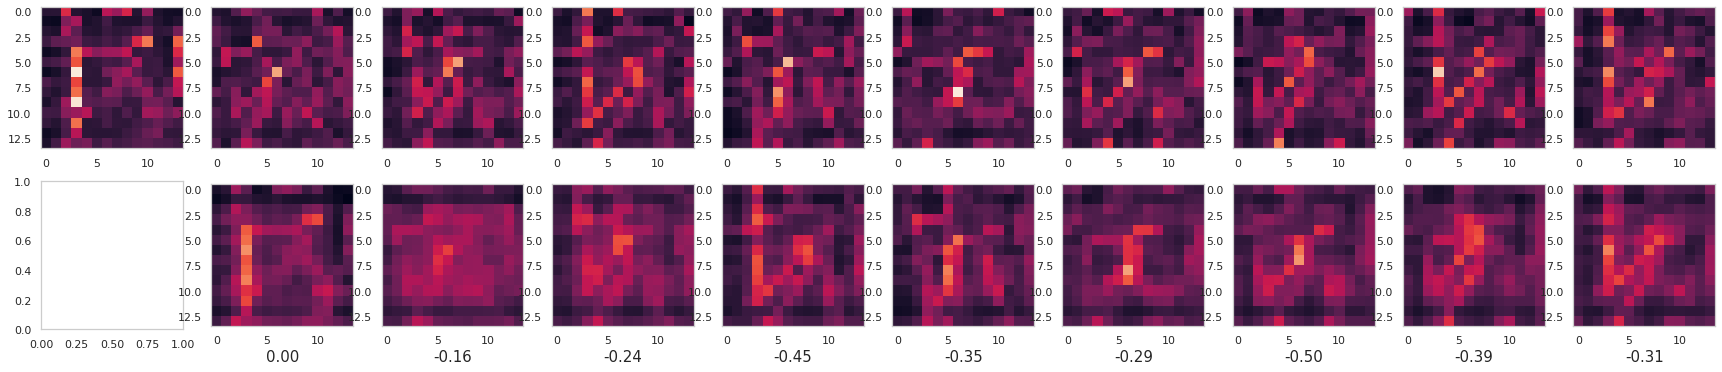

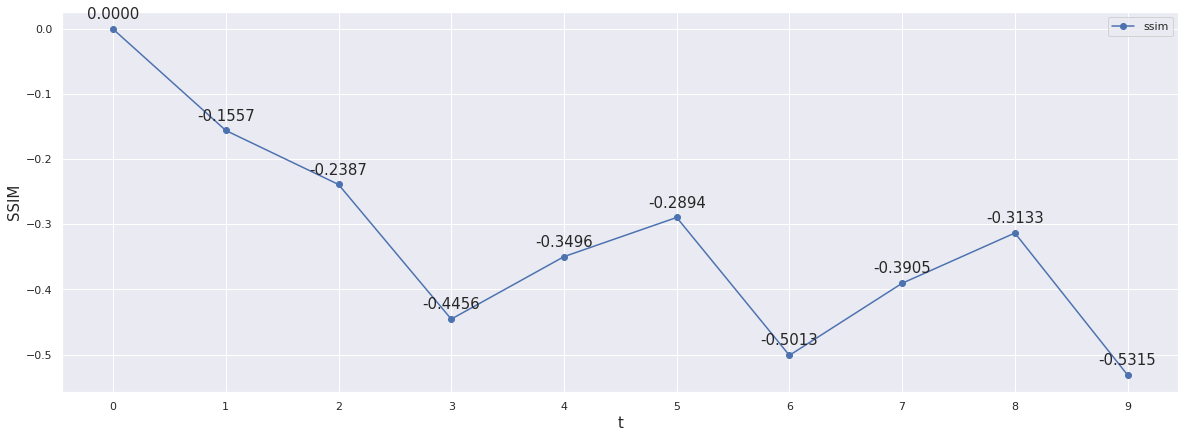

In [6]:
model_cfg = '../configs/model_cfgs/pipeline3_rgbspec_san19pairfreeze112@layer2-3_halluconvlstm2.yaml'
weight = '/home/knmac/Dropbox/SparseSensing/DGX_training_logs/pipeline3_rgbspec_san19pairfreeze112@layer2-3_halluconvlstm2/best.model'
ssim3 = run_experiment(model_cfg, weight, title=weight.split('/')[-2], display=True, new_num_segments=10)

# Compare SSIM curve

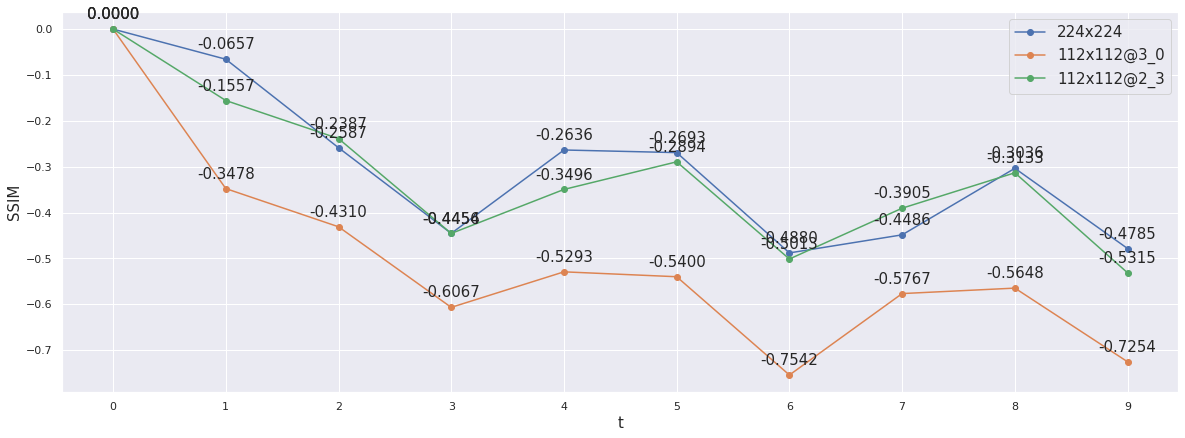

In [7]:
n_frames = 10
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
ax.plot(np.arange(10), ssim1, '-o', label='224x224')
ax.plot(np.arange(10), ssim2, '-o', label='112x112@3_0')
ax.plot(np.arange(10), ssim3, '-o', label='112x112@2_3')
#ax.plot(np.arange(model.num_segments), [theta]*model.num_segments, '--', label='theshold')

for t in range(n_frames):
    ax.annotate('{:.4f}'.format(ssim1[t]), (t, ssim1[t]), 
                textcoords='offset points', xytext=(0,n_frames), ha='center', fontsize=15)
    ax.annotate('{:.4f}'.format(ssim2[t]), (t, ssim2[t]), 
                textcoords='offset points', xytext=(0,n_frames), ha='center', fontsize=15)
    ax.annotate('{:.4f}'.format(ssim3[t]), (t, ssim3[t]), 
                textcoords='offset points', xytext=(0,n_frames), ha='center', fontsize=15)
    
ax.set_xlabel('t', fontsize=15)
ax.set_ylabel('SSIM', fontsize=15)
ax.set_xticks(np.arange(n_frames))
plt.legend(prop={'size': 15})